<a href="https://colab.research.google.com/github/megha-66/Deep-Learning-Lab-works-/blob/main/DL_Lab_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import ing the necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


In [ ]:
train = pd.read_csv(r'/content/DailyDelhiClimateTrain.csv')
test = pd.read_csv(r'/content/DailyDelhiClimateTest.csv')

In [ ]:
# 1. Handling Missing Values
imputer = SimpleImputer(strategy='mean')
train[['meantemp', 'humidity', 'wind_speed', 'meanpressure']] = imputer.fit_transform(train[['meantemp', 'humidity', 'wind_speed', 'meanpressure']])
test[['meantemp', 'humidity', 'wind_speed', 'meanpressure']] = imputer.transform(test[['meantemp', 'humidity', 'wind_speed', 'meanpressure']])


In [ ]:
# 2. Scaling Features
scaler = StandardScaler()
train[['meantemp', 'humidity', 'wind_speed', 'meanpressure']] = scaler.fit_transform(train[['meantemp', 'humidity', 'wind_speed', 'meanpressure']])
test[['meantemp', 'humidity', 'wind_speed', 'meanpressure']] = scaler.transform(test[['meantemp', 'humidity', 'wind_speed', 'meanpressure']])


In [ ]:
# 3. Feature Engineering - Date-based features
# Convert date column to datetime format if it isn't already
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [ ]:
# Extracting day, month, year, and day of the week
for df in [train, test]:
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_week'] = df['date'].dt.dayofweek

In [ ]:
# 4. Adding Lagged Features (e.g., previous day's meantemp, humidity, etc.)
# Sort by date to ensure proper lagging
train = train.sort_values('date')
test = test.sort_values('date')


# Adding lag features
for lag in range(1, 4):  # Example: 1-day, 2-day, and 3-day lags
    for col in ['meantemp', 'humidity', 'wind_speed', 'meanpressure']:
        train[f'{col}_lag_{lag}'] = train[col].shift(lag)
        test[f'{col}_lag_{lag}'] = test[col].shift(lag)

# Fill any NaN values generated by lagging with the column mean
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

In [ ]:
# 5. Outlier Handling (capping outliers using the IQR method)
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

for col in ['meantemp', 'humidity', 'wind_speed', 'meanpressure']:
    cap_outliers(train, col)
    cap_outliers(test, col)

In [ ]:
# Drop the 'date' column after feature extraction
train = train.drop(columns=['date'])
test = test.drop(columns=['date'])

# Final preprocessed data
print("Preprocessed train data:\n", train.head())
print("Preprocessed test data:\n", test.head())

Preprocessed train data:
    meantemp  humidity  wind_speed  meanpressure  day  month  year  \
0 -2.109500  1.415439   -1.491699      0.025321    1      1  2013   
1 -2.463454  1.862828   -0.838196      0.037162    2      1  2013   
2 -2.495219  1.564569   -0.475626      0.041972    3      1  2013   
3 -2.291015  0.630022   -1.221233      0.033647    4      1  2013   
4 -2.654044  1.554627   -0.680303      0.029946    5      1  2013   

   day_of_week  meantemp_lag_1  humidity_lag_1  wind_speed_lag_1  \
0            1        0.001444       -0.001602          0.001021   
1            2       -2.109500        1.415439         -1.491699   
2            3       -2.463454        1.862828         -0.838196   
3            4       -2.495219        1.564569         -0.475626   
4            5       -2.291015        0.630022         -1.221233   

   meanpressure_lag_1  meantemp_lag_2  humidity_lag_2  wind_speed_lag_2  \
0           -0.000019        0.002419       -0.002674          0.000943   


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam


# Define the feature columns (all columns except the target)
features = train.columns.difference(['meantemp'])

# Function to create sequences of data for LSTM input
def create_sequences(data, target, sequence_length=10):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)

# Normalize the feature columns before creating sequences
scaler = StandardScaler()
train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])

# Prepare sequences for the LSTM model
sequence_length = 10  # Adjust as needed based on time horizon
X_train, y_train = create_sequences(train[features].values, train['meantemp'].values, sequence_length)
X_test, y_test = create_sequences(test[features].values, test['meantemp'].values, sequence_length)

# Reshape X data for LSTM [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features)))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(features)))

# Define LSTM model architecture
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=3,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss (MSE): {loss}')

# Predicting on test data
y_pred = model.predict(X_test)

# Display some predictions vs true values
for i in range(10):
    print(f"True: {y_test[i]}, Predicted: {y_pred[i][0]}")


Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.4947 - val_loss: 0.2263
Epoch 2/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1198 - val_loss: 0.2385
Epoch 3/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1074 - val_loss: 0.1779
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1794 
Test Loss (MSE): 0.17790737748146057
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
True: -1.97336389685598, Predicted: -1.024849534034729
True: -1.8658880149655506, Predicted: -1.1018143892288208
True: -1.6690596351897444, Predicted: -1.1705682277679443
True: -1.6738644393213167, Predicted: -1.2153958082199097
True: -1.233493695436357, Predicted: -1.269193410873413
True: -1.476467069582561, Predicted: -1.3355447053909302
True: -1.8750433678673282, Predicted: -1.356414794921875
True: -1.695419324522675, Predicted: -1.3662066459655762
True: -1.4806808065392174, Predicted: -1.3615422248840332
True: -1.3929941346476609, Predicted: -1.4188064336776733



Training model with learning rate = 0.001
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.3386 - val_loss: 0.1851
Epoch 2/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1048 - val_loss: 0.1937
Epoch 3/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0971 - val_loss: 0.2033
Epoch 4/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0920 - val_loss: 0.1593
Epoch 5/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0926 - val_loss: 0.1546
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step

Training model with learning rate = 0.01
Epoch 1/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.2568 - val_loss: 0.1368
Epoch 2/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1124 - val_loss: 0.1261
Epoch 3/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0837 - val_loss: 0.2054
Epoch 4/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0927 - val_loss: 0.1594
Epoch 5/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0891 - val_loss: 0.1219
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step

Training model with learning rate = 0.0005
Epoch 

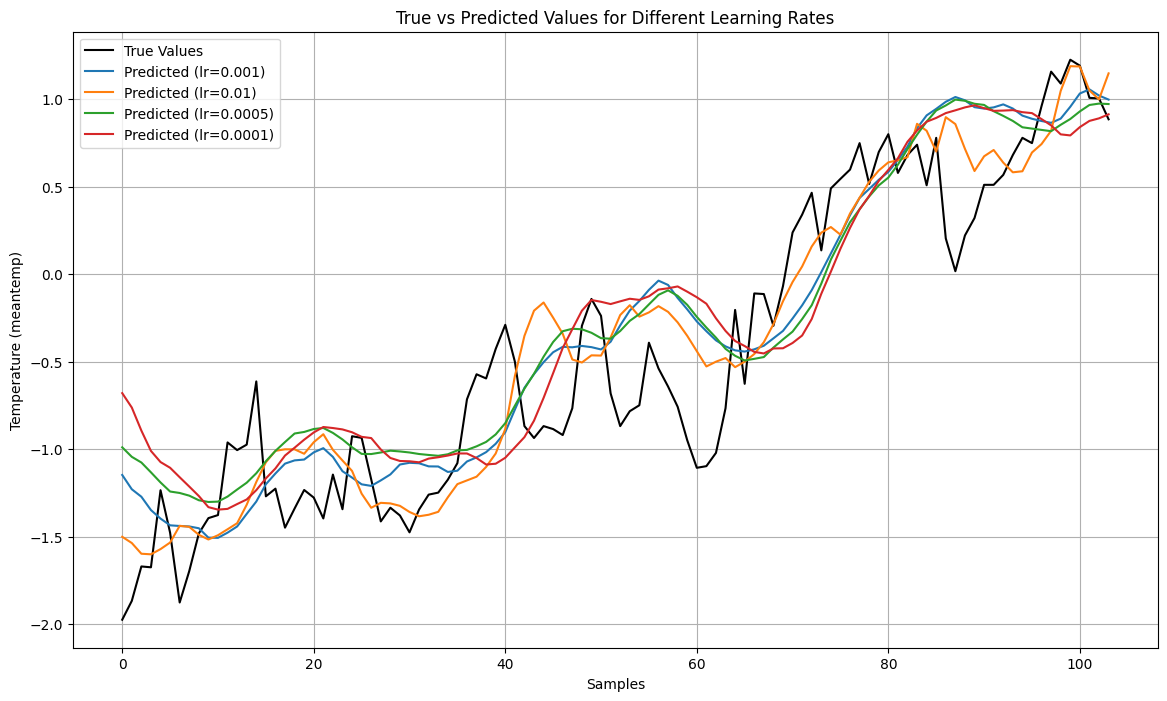

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Define a function to create and compile an LSTM model with a given learning rate
def create_lstm_model(learning_rate):
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer for regression

    # Compile model with specified learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# List of learning rates to try
learning_rates = [0.001, 0.01, 0.0005, 0.0001]
predictions_dict1 = {}

# Train models with different learning rates and store predictions
for lr in learning_rates:
    print(f"\nTraining model with learning rate = {lr}")
    model = create_lstm_model(learning_rate=lr)
    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Predict on test data
    y_pred = model.predict(X_test).flatten()
    predictions_dict1[lr] = y_pred

# Visualization of true vs predicted values for each learning rate
plt.figure(figsize=(14, 8))

# Plot true values
plt.plot(y_test, label='True Values', color='black')

# Plot predictions for each learning rate
for lr, y_pred in predictions_dict1.items():
    plt.plot(y_pred, label=f'Predicted (lr={lr})')

plt.xlabel('Samples')
plt.ylabel('Temperature (meantemp)')
plt.title('True vs Predicted Values for Different Learning Rates')
plt.legend()
plt.grid()
plt.show()


Evaluation Results for Different Learning Rates:
                    MAE       MSE      RMSE      MAPE
Learning Rate                                        
0.0010         0.329103  0.154590  0.393179  1.149935
0.0100         0.283868  0.121875  0.349106  0.965352
0.0005         0.352437  0.173121  0.416078  1.165122
0.0001         0.378837  0.211878  0.460302  1.163421


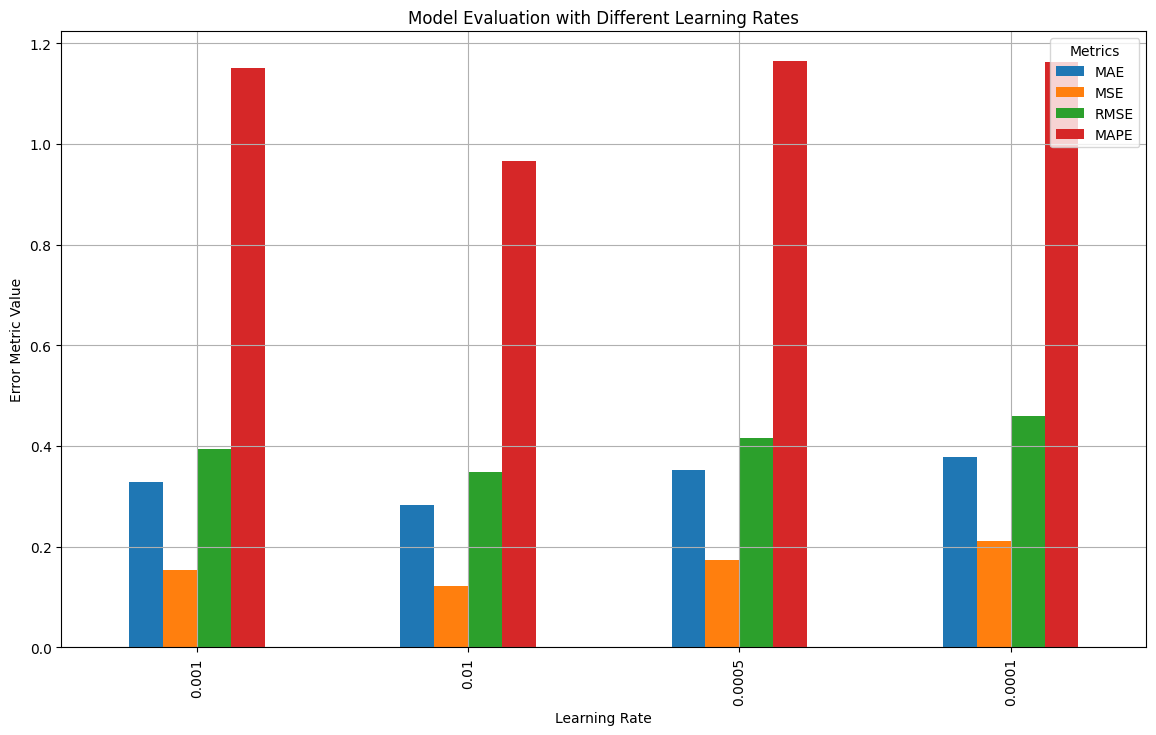

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# Dictionary to store evaluation results for different learning rates
evaluation_results_lr = {}

# Calculate evaluation metrics for each learning rate
for lr, y_pred in predictions_dict1.items():
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Store results
    evaluation_results_lr[lr] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

# Convert results to a DataFrame for easier visualization
evaluation_df_lr = pd.DataFrame(evaluation_results_lr).T
evaluation_df_lr.index.name = 'Learning Rate'

# Print out the evaluation results
print("Evaluation Results for Different Learning Rates:")
print(evaluation_df_lr)

# Plot the evaluation metrics for each learning rate
evaluation_df_lr.plot(kind='bar', figsize=(14, 8))
plt.title('Model Evaluation with Different Learning Rates')
plt.xlabel('Learning Rate')
plt.ylabel('Error Metric Value')
plt.grid(True)
plt.legend(title="Metrics", loc='upper right')
plt.show()



Training model with activation function = tanh
Epoch 1/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.2669 - val_loss: 0.2631
Epoch 2/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1179 - val_loss: 0.1448
Epoch 3/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0946 - val_loss: 0.1994
Epoch 4/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0885 - val_loss: 0.1899
Epoch 5/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0840 - val_loss: 0.1612
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step

Training model with activation function = relu
Epoch 1/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 1.3163 - val_loss: 0.3607
Epoch 2/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1485 - val_loss: 0.1697
Epoch 3/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1203 - val_loss: 0.2013
Epoch 4/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1252 - val_loss: 0.1717
Epoch 5/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0980 - val_loss: 0.1492
4/4 ━━━━━━━━━━━━━━━━━━━━ 

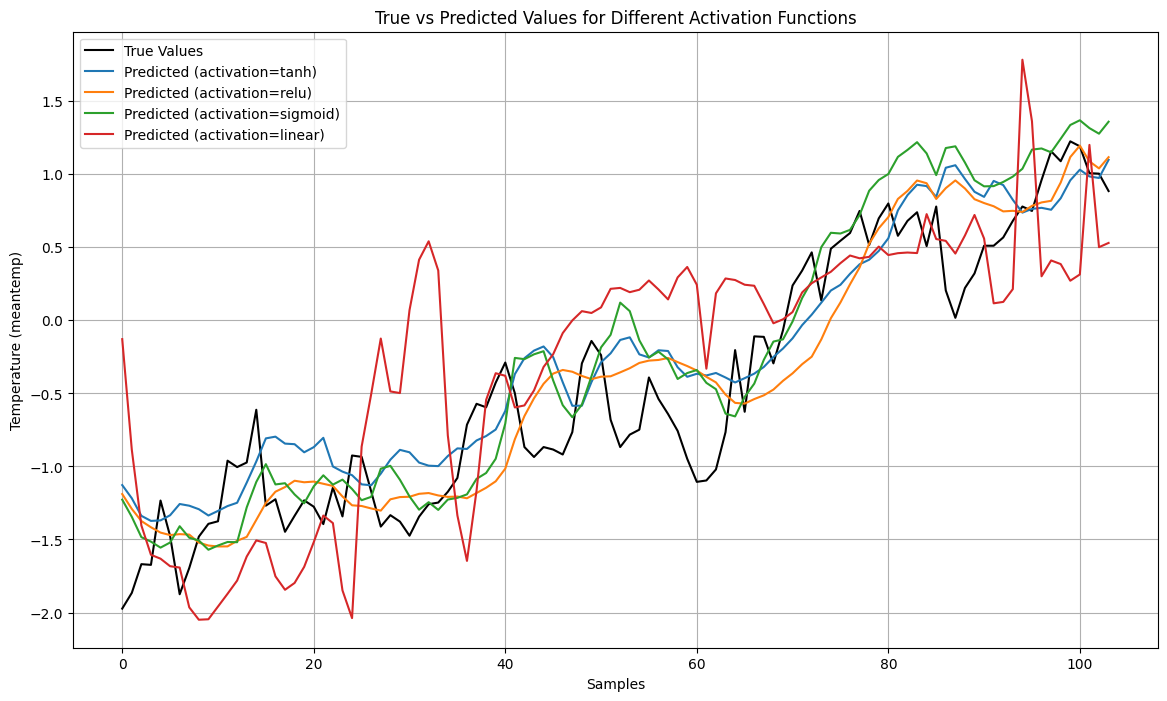

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Define a function to create and compile an LSTM model with a given activation function
def create_lstm_model(activation):
    model = Sequential()
    model.add(LSTM(64, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation=activation, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer for regression

    # Compile model with a fixed learning rate of 0.01
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    return model

# List of activation functions to try
activation_functions = ['tanh', 'relu', 'sigmoid', 'linear']
predictions_dict = {}

# Train models with different activation functions and store predictions
for activation in activation_functions:
    print(f"\nTraining model with activation function = {activation}")
    model = create_lstm_model(activation=activation)
    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Predict on test data
    y_pred = model.predict(X_test).flatten()
    predictions_dict[activation] = y_pred

# Visualization of true vs predicted values for each activation function
plt.figure(figsize=(14, 8))

# Plot true values
plt.plot(y_test, label='True Values', color='black')

# Plot predictions for each activation function
for activation, y_pred in predictions_dict.items():
    plt.plot(y_pred, label=f'Predicted (activation={activation})')

plt.xlabel('Samples')
plt.ylabel('Temperature (meantemp)')
plt.title('True vs Predicted Values for Different Activation Functions')
plt.legend()
plt.grid()
plt.show()


Evaluation Results:
              MAE       MSE      RMSE      MAPE
tanh     0.339602  0.161198  0.401495  1.112587
relu     0.315828  0.149190  0.386252  1.151256
sigmoid  0.335124  0.169316  0.411480  1.231796
linear   0.563863  0.492871  0.702047  0.994680


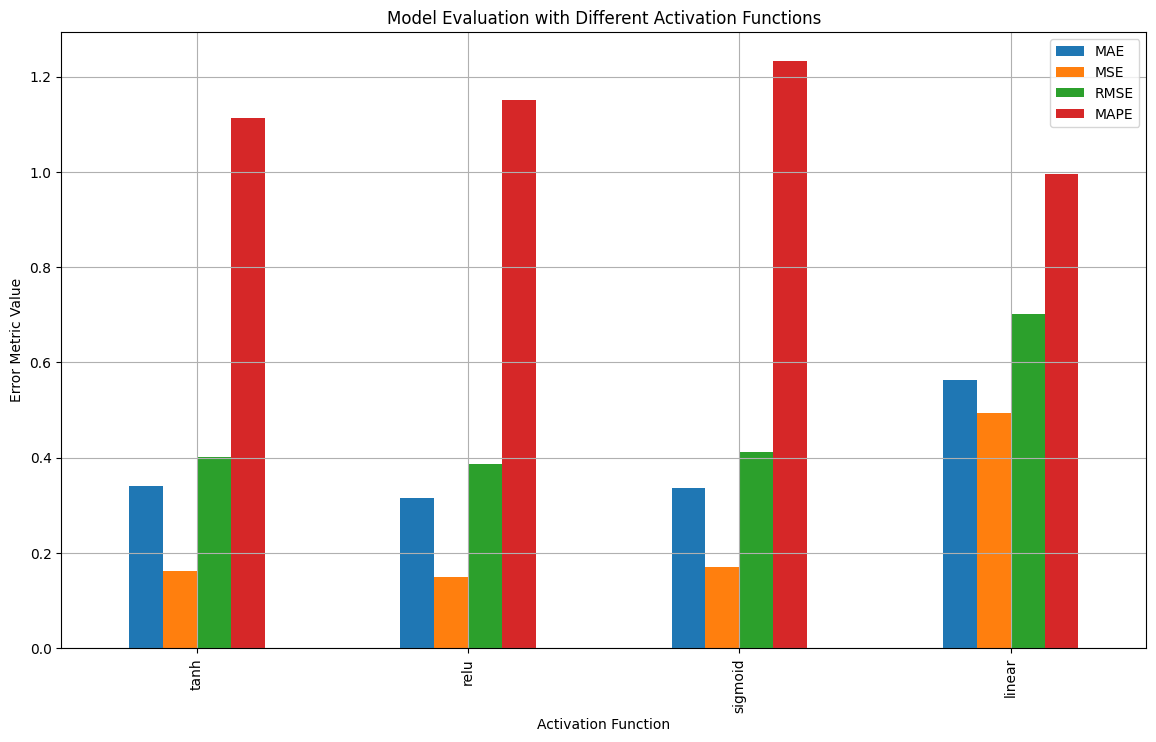

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# Dictionary to store evaluation results
evaluation_results = {}

# Calculate evaluation metrics for each activation function
for activation, y_pred in predictions_dict.items():
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Store results
    evaluation_results[activation] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

# Convert results to a DataFrame for easier visualization
evaluation_df = pd.DataFrame(evaluation_results).T

# Print out the evaluation results
print("Evaluation Results:")
print(evaluation_df)

# Plot the evaluation metrics for each activation function
evaluation_df.plot(kind='bar', figsize=(14, 8))
plt.title('Model Evaluation with Different Activation Functions')
plt.xlabel('Activation Function')
plt.ylabel('Error Metric Value')
plt.grid(True)
plt.show()
